# Transit Development & Accessibility

Accessibility to transportation has long been considered to have an effect on quality of life indicators such as health, education, and income. Communities with limited access to roads, and transportation options limits their ability to integrate more with the outside world. In urban areas, this often translates into residents of neighborhoods with underrepresented populations not having equitable access to the city’s public transit system, thus making it difficult for them to have easy access to employment, schooling, and health facilities.

### PMPML Stop and Lines Data

The Pune Mahanagar Parivahan Mahamandal Limited (PMPML) is the body which runs the bus system in the Greater Pune Area (Pune City, Pimpri-Chinchwad and the periurban areas).

The data includes information on the following variables:
1. Route ID
1. Stop ID (unique for the route) Each stop will have multiple stop IDs corresponding to the number of routes servicing it
1. Stop Name
1. Latitude and Longitude

Interesting values we can derive from this could be:
1. Stop Density : How many stops per ward, or population per stop for a given ward
1. Stop Usability : How many lines pass through a particular stop?

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium
import pandas as pd
import pysal as ps
import seaborn as sns
import statsmodels.api as sm
from cartopy import crs as ccrs
from geopy.distance import great_circle
from shapely.geometry import Point
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

np.random.seed(0)
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Loading the PMPML data:

In [2]:
pmpml = pd.read_csv("data/pmpml.csv")

In [3]:
pmpml['LONG'] = pmpml['LONG'].fillna(0)

In [4]:
pmpml['LAT'] = pmpml['LAT'].fillna(0)

In [5]:
pmpml.head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage
0,1,BRTS,100-D,100-D-01,1,Hinjawadi Maan Phase 3,18.576553,73.688178,1
1,2,BRTS,100-D,100-D-02,2,Tech Mahindra,18.581016,73.687704,1
2,3,BRTS,100-D,100-D-03,3,Tata Motors,18.586860,73.700098,2
3,4,BRTS,100-D,100-D-04,4,Power House Hinjawadi,18.588990,73.705400,2
4,5,BRTS,100-D,100-D-05,5,Infosys Phase 2,18.593741,73.708210,3


In [6]:
pmpml_agg = pmpml.drop_duplicates('Stop.Name').dropna()

We now aggregate the dataframe by the stop names to get a unique count of lines per stop.

In [7]:
grp = pmpml.groupby('Stop.Name')
grp1 = grp['Stop.Name'].count()
grp1 = pd.DataFrame({'Stop.Name':grp1.index, 'line_count':grp1.values})



In [8]:
grp1.head()

,Stop.Name,line_count
0,,1
1,10 Wa Mile Wadki,6
2,12 Wa Mile,6
3,15 August Chowk,23
4,15 Number,33


We now merge the two dataframes, to create a new dataframe which is aggregated by the stop names, so that each row is a unique entry pertaining to a unique bus stop. We also get a new column which relates to the number of unique routes (both up and down, and nightly services) a stop is serviced by. This count does not neccessarily mean the number of lines, but rather unique routes.

In [9]:
stopsmerge = pd.merge(pmpml_agg, grp1, on='Stop.Name', how='outer')

In [10]:
stopsmerge.head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count
0,1.0,BRTS,100-D,100-D-01,1,Hinjawadi Maan Phase 3,18.576553,73.688178,1,32
1,2.0,BRTS,100-D,100-D-02,2,Tech Mahindra,18.581016,73.687704,1,31
2,3.0,BRTS,100-D,100-D-03,3,Tata Motors,18.586860,73.700098,2,33
3,4.0,BRTS,100-D,100-D-04,4,Power House Hinjawadi,18.588990,73.705400,2,33
4,5.0,BRTS,100-D,100-D-05,5,Infosys Phase 2,18.593741,73.708210,3,33


In [11]:
pmpml = gpd.GeoDataFrame(stopsmerge)
pmpml.head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count
0,1.0,BRTS,100-D,100-D-01,1,Hinjawadi Maan Phase 3,18.576553,73.688178,1,32
1,2.0,BRTS,100-D,100-D-02,2,Tech Mahindra,18.581016,73.687704,1,31
2,3.0,BRTS,100-D,100-D-03,3,Tata Motors,18.586860,73.700098,2,33
3,4.0,BRTS,100-D,100-D-04,4,Power House Hinjawadi,18.588990,73.705400,2,33
4,5.0,BRTS,100-D,100-D-05,5,Infosys Phase 2,18.593741,73.708210,3,33


We now add the geometry column generated from the LAT and LONG columns.

In [12]:
pmpml['geometry'] = pmpml.apply(lambda row: Point(row['LONG'], row['LAT']), axis=1)

In [13]:
pmpml.head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
0,1.0,BRTS,100-D,100-D-01,1,Hinjawadi Maan Phase 3,18.576553,73.688178,1,32,POINT (73.68817800000001 18.576553)
1,2.0,BRTS,100-D,100-D-02,2,Tech Mahindra,18.581016,73.687704,1,31,POINT (73.68770400000001 18.581016)
2,3.0,BRTS,100-D,100-D-03,3,Tata Motors,18.586860,73.700098,2,33,POINT (73.700098 18.58686)
3,4.0,BRTS,100-D,100-D-04,4,Power House Hinjawadi,18.588990,73.705400,2,33,POINT (73.7054 18.58899)
4,5.0,BRTS,100-D,100-D-05,5,Infosys Phase 2,18.593741,73.708210,3,33,POINT (73.70820999999999 18.593741)


In [14]:
pmpml.sort_values(by=['LONG'], ascending = True).head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
2270,26782.0,Route Type,Route,Stop Code,Stop Seq,Stop Name,0.000000,0.000000,Stage,1,POINT (0 0)
1414,11308.0,Non-BRTS,257-D,257-D-04,4,Suyash Mangal Karyalay,18.673210,3.909530,2,2,POINT (3.90953 18.67321)
2162,23955.0,Non-BRTS,70-D,70-D-00,0,Sheregaon,18.531138,73.558592,1,4,POINT (73.558592 18.531138)
2163,23956.0,Non-BRTS,70-D,70-D-01,1,Hotel Vitthal Kamat,18.531140,73.560751,1,4,POINT (73.560751 18.53114)
2164,23957.0,Non-BRTS,70-D,70-D-02,2,Dagade Patil Farm,18.530819,73.568121,1,4,POINT (73.56812099999999 18.530819)


In [15]:
pmpml.sort_values(by=['LONG'], ascending = True).tail()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
908,5672.0,BRTS,159-D,159-D-03,3,ST Stand Grampanchayat Talegaon,18.667490,74.150120,2,2,POINT (74.15012 18.66749)
907,5671.0,BRTS,159-D,159-D-02,2,Godown Talegaon Dhamdhere,18.665761,74.153720,1,2,POINT (74.15371999999999 18.665761)
796,4594.0,Non-BRTS,147-D,147-D-00,0,Nhavi Sandas,18.605578,74.155777,1,4,POINT (74.155777 18.605578)
906,5670.0,BRTS,159-D,159-D-01,1,Talegaon Dhamdhere Bazar,18.667027,74.156785,1,2,POINT (74.156785 18.667027)
2394,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,1,POINT (nan nan)


In [16]:
pmpml = pmpml[np.isfinite(pmpml['LAT'])]
pmpml = pmpml[np.isfinite(pmpml['LONG'])]

In [17]:
pmpml = pmpml[pmpml['LAT'] >= 18]
pmpml = pmpml[pmpml['LONG'] >= 73]

In [18]:
pmpml.sort_values(by=['LONG'], ascending = True).head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
2162,23955.0,Non-BRTS,70-D,70-D-00,0,Sheregaon,18.531138,73.558592,1,4,POINT (73.558592 18.531138)
2163,23956.0,Non-BRTS,70-D,70-D-01,1,Hotel Vitthal Kamat,18.531140,73.560751,1,4,POINT (73.560751 18.53114)
2164,23957.0,Non-BRTS,70-D,70-D-02,2,Dagade Patil Farm,18.530819,73.568121,1,4,POINT (73.56812099999999 18.530819)
2165,23958.0,Non-BRTS,70-D,70-D-03,3,Akole Bus Stop,18.529042,73.572062,2,4,POINT (73.572062 18.529042)
2166,23959.0,Non-BRTS,70-D,70-D-04,4,Deshpande Farm,18.527805,73.574681,2,4,POINT (73.57468100000001 18.527805)


In [19]:
pmpml.sort_values(by=['LONG'], ascending = True).tail()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
909,5673.0,BRTS,159-D,159-D-04,4,ITI Talegaon Dhamdhere,18.670997,74.146480,2,2,POINT (74.14648000000001 18.670997)
908,5672.0,BRTS,159-D,159-D-03,3,ST Stand Grampanchayat Talegaon,18.667490,74.150120,2,2,POINT (74.15012 18.66749)
907,5671.0,BRTS,159-D,159-D-02,2,Godown Talegaon Dhamdhere,18.665761,74.153720,1,2,POINT (74.15371999999999 18.665761)
796,4594.0,Non-BRTS,147-D,147-D-00,0,Nhavi Sandas,18.605578,74.155777,1,4,POINT (74.155777 18.605578)
906,5670.0,BRTS,159-D,159-D-01,1,Talegaon Dhamdhere Bazar,18.667027,74.156785,1,2,POINT (74.156785 18.667027)


In [20]:
pmpml.sort_values(by=['LAT'], ascending = True).head()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
2096,22979.0,Non-BRTS,61-D,61-D-00,0,Nasrapur,18.250780,73.880398,1,2,POINT (73.880398 18.25078)
2097,22980.0,Non-BRTS,61-D,61-D-01,1,ST Stand Nasrapur,18.255040,73.883631,1,2,POINT (73.88363100000001 18.25504)
2098,22981.0,Non-BRTS,61-D,61-D-02,2,Dalvivasti,18.258873,73.885246,1,2,POINT (73.885246 18.258873)
2099,22982.0,Non-BRTS,61-D,61-D-03,3,Cheladi Phata,18.266930,73.881308,2,2,POINT (73.88130799999999 18.26693)
2100,22983.0,Non-BRTS,61-D,61-D-04,4,Mahaveer Company,18.269679,73.880154,2,2,POINT (73.880154 18.269679)


In [21]:
pmpml.sort_values(by=['LONG'], ascending = True).tail()

,Unnamed: 0,Route.Type,Route,Stop.Code,Stop.Seq,Stop.Name,LAT,LONG,Stage,line_count,geometry
909,5673.0,BRTS,159-D,159-D-04,4,ITI Talegaon Dhamdhere,18.670997,74.146480,2,2,POINT (74.14648000000001 18.670997)
908,5672.0,BRTS,159-D,159-D-03,3,ST Stand Grampanchayat Talegaon,18.667490,74.150120,2,2,POINT (74.15012 18.66749)
907,5671.0,BRTS,159-D,159-D-02,2,Godown Talegaon Dhamdhere,18.665761,74.153720,1,2,POINT (74.15371999999999 18.665761)
796,4594.0,Non-BRTS,147-D,147-D-00,0,Nhavi Sandas,18.605578,74.155777,1,4,POINT (74.155777 18.605578)
906,5670.0,BRTS,159-D,159-D-01,1,Talegaon Dhamdhere Bazar,18.667027,74.156785,1,2,POINT (74.156785 18.667027)


We have now cleaned our dataframe from any incident errors.

### Now Importing the Pune Census Ward Shapefile

In [22]:
pnq_census = gpd.read_file("data/PCA_complete/PCA_complete.shp")
pnq_census = gpd.GeoDataFrame(pnq_census)

In [23]:
pnq_census.head()

,Ward,No_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,P_SC,M_SC,...,str_per_P,P_per_str,str_dens_n,int_per_P,P_per_int,area_sqkm,pop_dens,pop_dens_n,dens_ratio,geometry
0,1,10452,44060,23099,20961,5686,2993,2693,8216,4202,...,0.030971,32.288536,1.000000,0.000409,2447.777778,0.123695,356198.714580,1.000000,0.000000,"POLYGON ((73.86329999999998 18.50339199999998,..."
1,2,5933,25430,13125,12305,3054,1591,1463,3887,1985,...,0.133246,7.504931,0.228559,0.001455,687.297297,0.220372,115395.785308,0.321688,0.093128,"POLYGON ((73.87355099999998 18.50539199999999,..."
2,3,5487,22592,11528,11064,2487,1347,1140,4846,2444,...,0.346288,2.887771,0.084841,0.003984,251.022222,0.466470,48431.839132,0.133059,0.048218,"POLYGON ((73.85167599999997 18.46751599999998,..."
3,4,5906,24678,12830,11848,2586,1367,1219,3478,1744,...,0.322493,3.100846,0.091473,0.002715,368.328358,0.685793,35984.619266,0.097996,0.006523,"POLYGON ((73.95740699999999 18.49487099999997,..."
4,5,4242,18490,9378,9112,1972,1023,949,5611,2801,...,0.331273,3.018659,0.088915,0.003786,264.142857,0.298112,62023.668957,0.171345,0.082430,"POLYGON ((73.84239199999999 18.49872899999999,..."


In [24]:
pnq_census.crs = {'init' :'epsg:4326'}

In [25]:
pmpml.crs = {'init' :'epsg:4326'}

In [26]:
#pmpml = pmpml.to_crs(pnq_census.crs)
pmpml.crs == pnq_census.crs

True

We have now cleaned our data to get all the necessary variables and we can proceed to map our stops

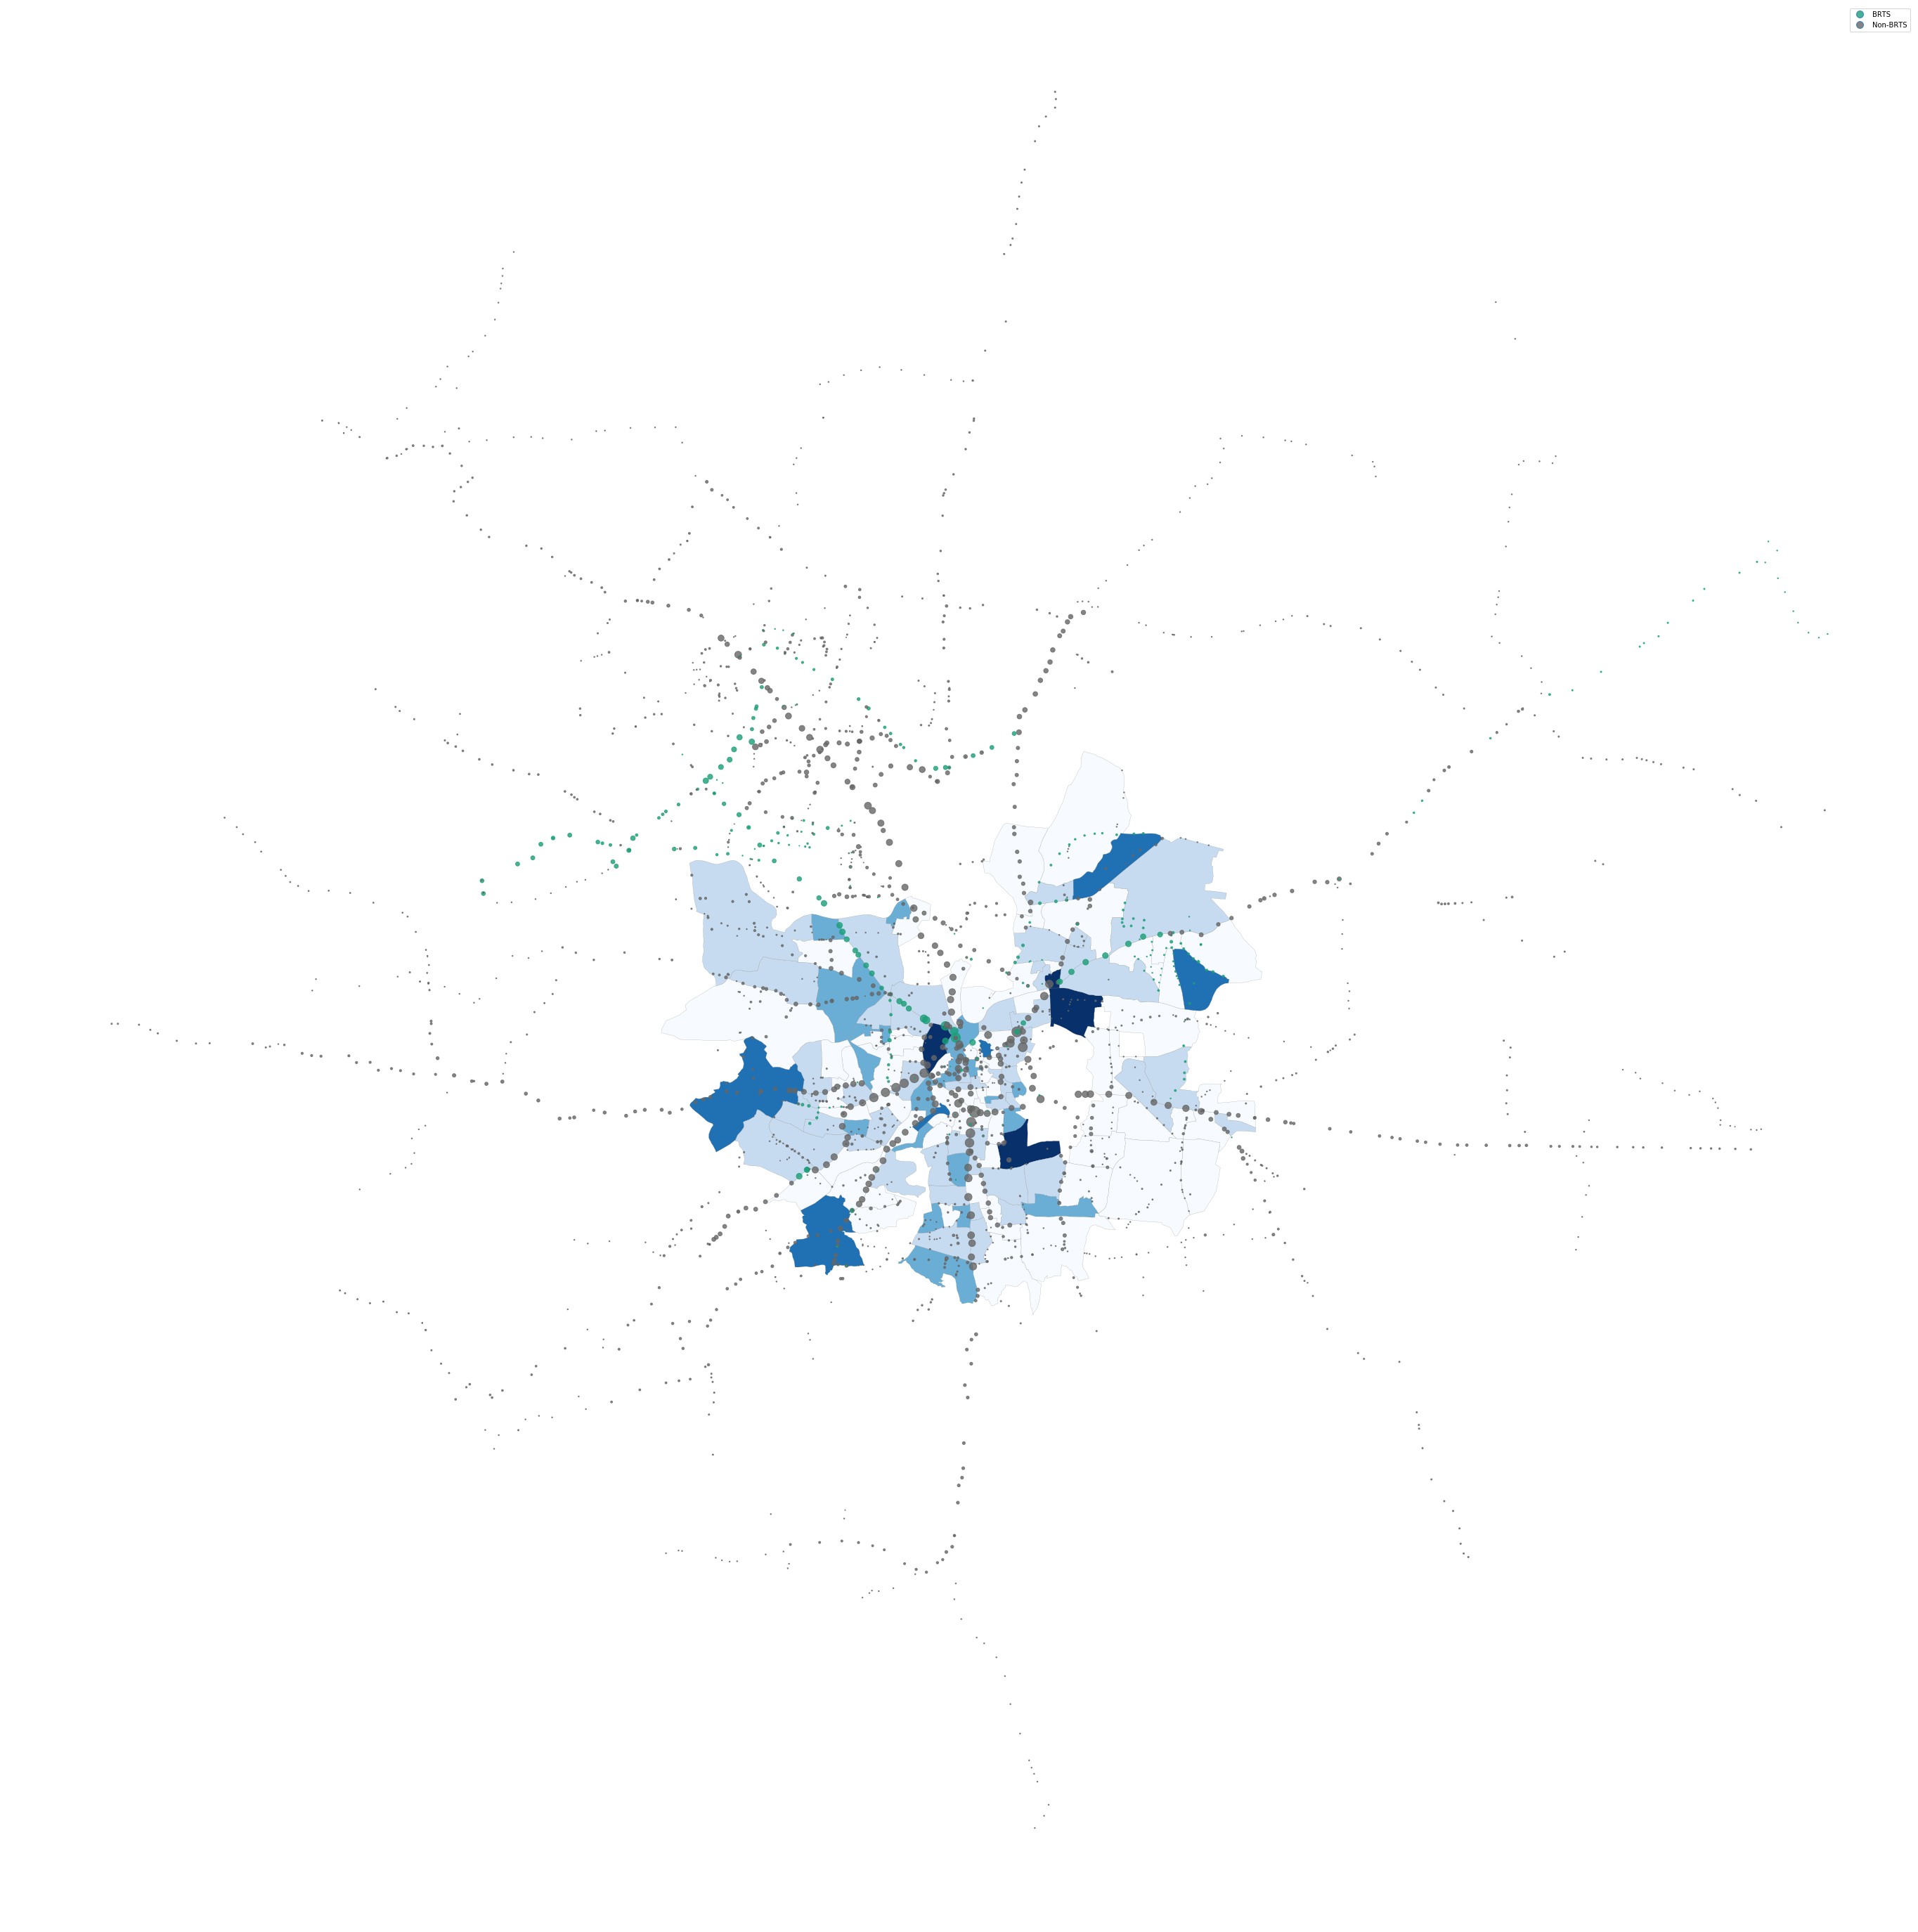

In [27]:
fig, ax = plt.subplots(figsize=(50, 50))

# plot the basemap: the country boundaries
ax = pnq_census.plot(ax=ax, 
                     column='pct_scst', 
                     cmap = 'Blues',
                     edgecolor='grey', 
                     lw=0.2,
                     scheme = 'Equal_Interval',
                     k = 5,
                    legend = True)

# plot the points: the city lat-lngs
ax = pmpml.plot(ax=ax, column='Route.Type', cmap = 'Dark2', markersize = 'line_count', lw=1, alpha=0.8, legend = True)

ax.axis('off')
plt.show()

In [28]:
pnq_bus = gpd.sjoin(pmpml, pnq_census, how='left', op='within')

In [29]:
groups = pnq_bus.groupby('name')

In [30]:
stpcnt = groups['line_count'].count()
stpcnt_m = pd.DataFrame({'name':stpcnt.index, 'stop_count':stpcnt.values})

In [31]:
stpcnt_m.head()

,name,stop_count
0,Aga Khan Palace,3
1,Agam Mandir Katraj,15
2,Agricultural College,10
3,Anandnagar - Hingne Khurd,2
4,Aundh Gaon,7


In [32]:
linesmed = groups['line_count'].median()
linesmed_m = pd.DataFrame({'name':linesmed.index, 'lines_median':linesmed.values})

In [33]:
linesmed_m.head()

,name,lines_median
0,Aga Khan Palace,4.0
1,Agam Mandir Katraj,8.0
2,Agricultural College,27.0
3,Anandnagar - Hingne Khurd,2.0
4,Aundh Gaon,7.0


In [34]:
stops_deets = pd.merge(stpcnt_m, linesmed_m, on='name', how='outer')

In [35]:
stops_deets.head()

,name,stop_count,lines_median
0,Aga Khan Palace,3,4.0
1,Agam Mandir Katraj,15,8.0
2,Agricultural College,10,27.0
3,Anandnagar - Hingne Khurd,2,2.0
4,Aundh Gaon,7,7.0


We merge this data with the main PCA Database (pnq_census)

In [36]:
pnq_census = pnq_census.merge(stops_deets, on='name')

We get the description of the cen

In [37]:
pnq_census['stop_count'].describe()

count    137.000000
mean       7.313869
std        5.844494
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       33.000000
Name: stop_count, dtype: float64

In [38]:
pnq_census['lines_median'].describe()

count    137.000000
mean      20.281022
std       24.239754
min        2.000000
25%        4.000000
50%        8.000000
75%       29.000000
max      117.000000
Name: lines_median, dtype: float64

Calculating Population per Bus Stop:

In [39]:
pnq_census['stops_per_1000P'] = (pnq_census['stop_count'] / pnq_census['TOT_P']) * 1000

In [40]:
pnq_census.head()

,Ward,No_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,P_SC,M_SC,...,int_per_P,P_per_int,area_sqkm,pop_dens,pop_dens_n,dens_ratio,geometry,stop_count,lines_median,stops_per_1000P
0,3,5487,22592,11528,11064,2487,1347,1140,4846,2444,...,0.003984,251.022222,0.466470,48431.839132,0.133059,0.048218,"POLYGON ((73.85167599999997 18.46751599999998,...",3,8.0,0.132790
1,4,5906,24678,12830,11848,2586,1367,1219,3478,1744,...,0.002715,368.328358,0.685793,35984.619266,0.097996,0.006523,"POLYGON ((73.95740699999999 18.49487099999997,...",1,34.0,0.040522
2,5,4242,18490,9378,9112,1972,1023,949,5611,2801,...,0.003786,264.142857,0.298112,62023.668957,0.171345,0.082430,"POLYGON ((73.84239199999999 18.49872899999999,...",3,20.0,0.162250
3,6,5241,26134,15086,11048,2315,1217,1098,5419,2885,...,0.001492,670.102564,0.652153,40073.418354,0.109514,-0.077854,"POLYGON ((73.86938099999998 18.49297199999999,...",1,54.0,0.038264
4,7,8764,33810,17610,16200,3694,1865,1829,5560,2795,...,0.001006,994.411765,1.348008,25081.453523,0.067283,-0.179410,"POLYGON ((73.86073399999998 18.53156099999999,...",1,40.0,0.029577


### Mapping Stops per 1000 residents of a Census Ward with Bus stops:

Bus stops are marked by whether they are BRTS(green) or non-BRTS(grey), and sized according to the number of routes being served.

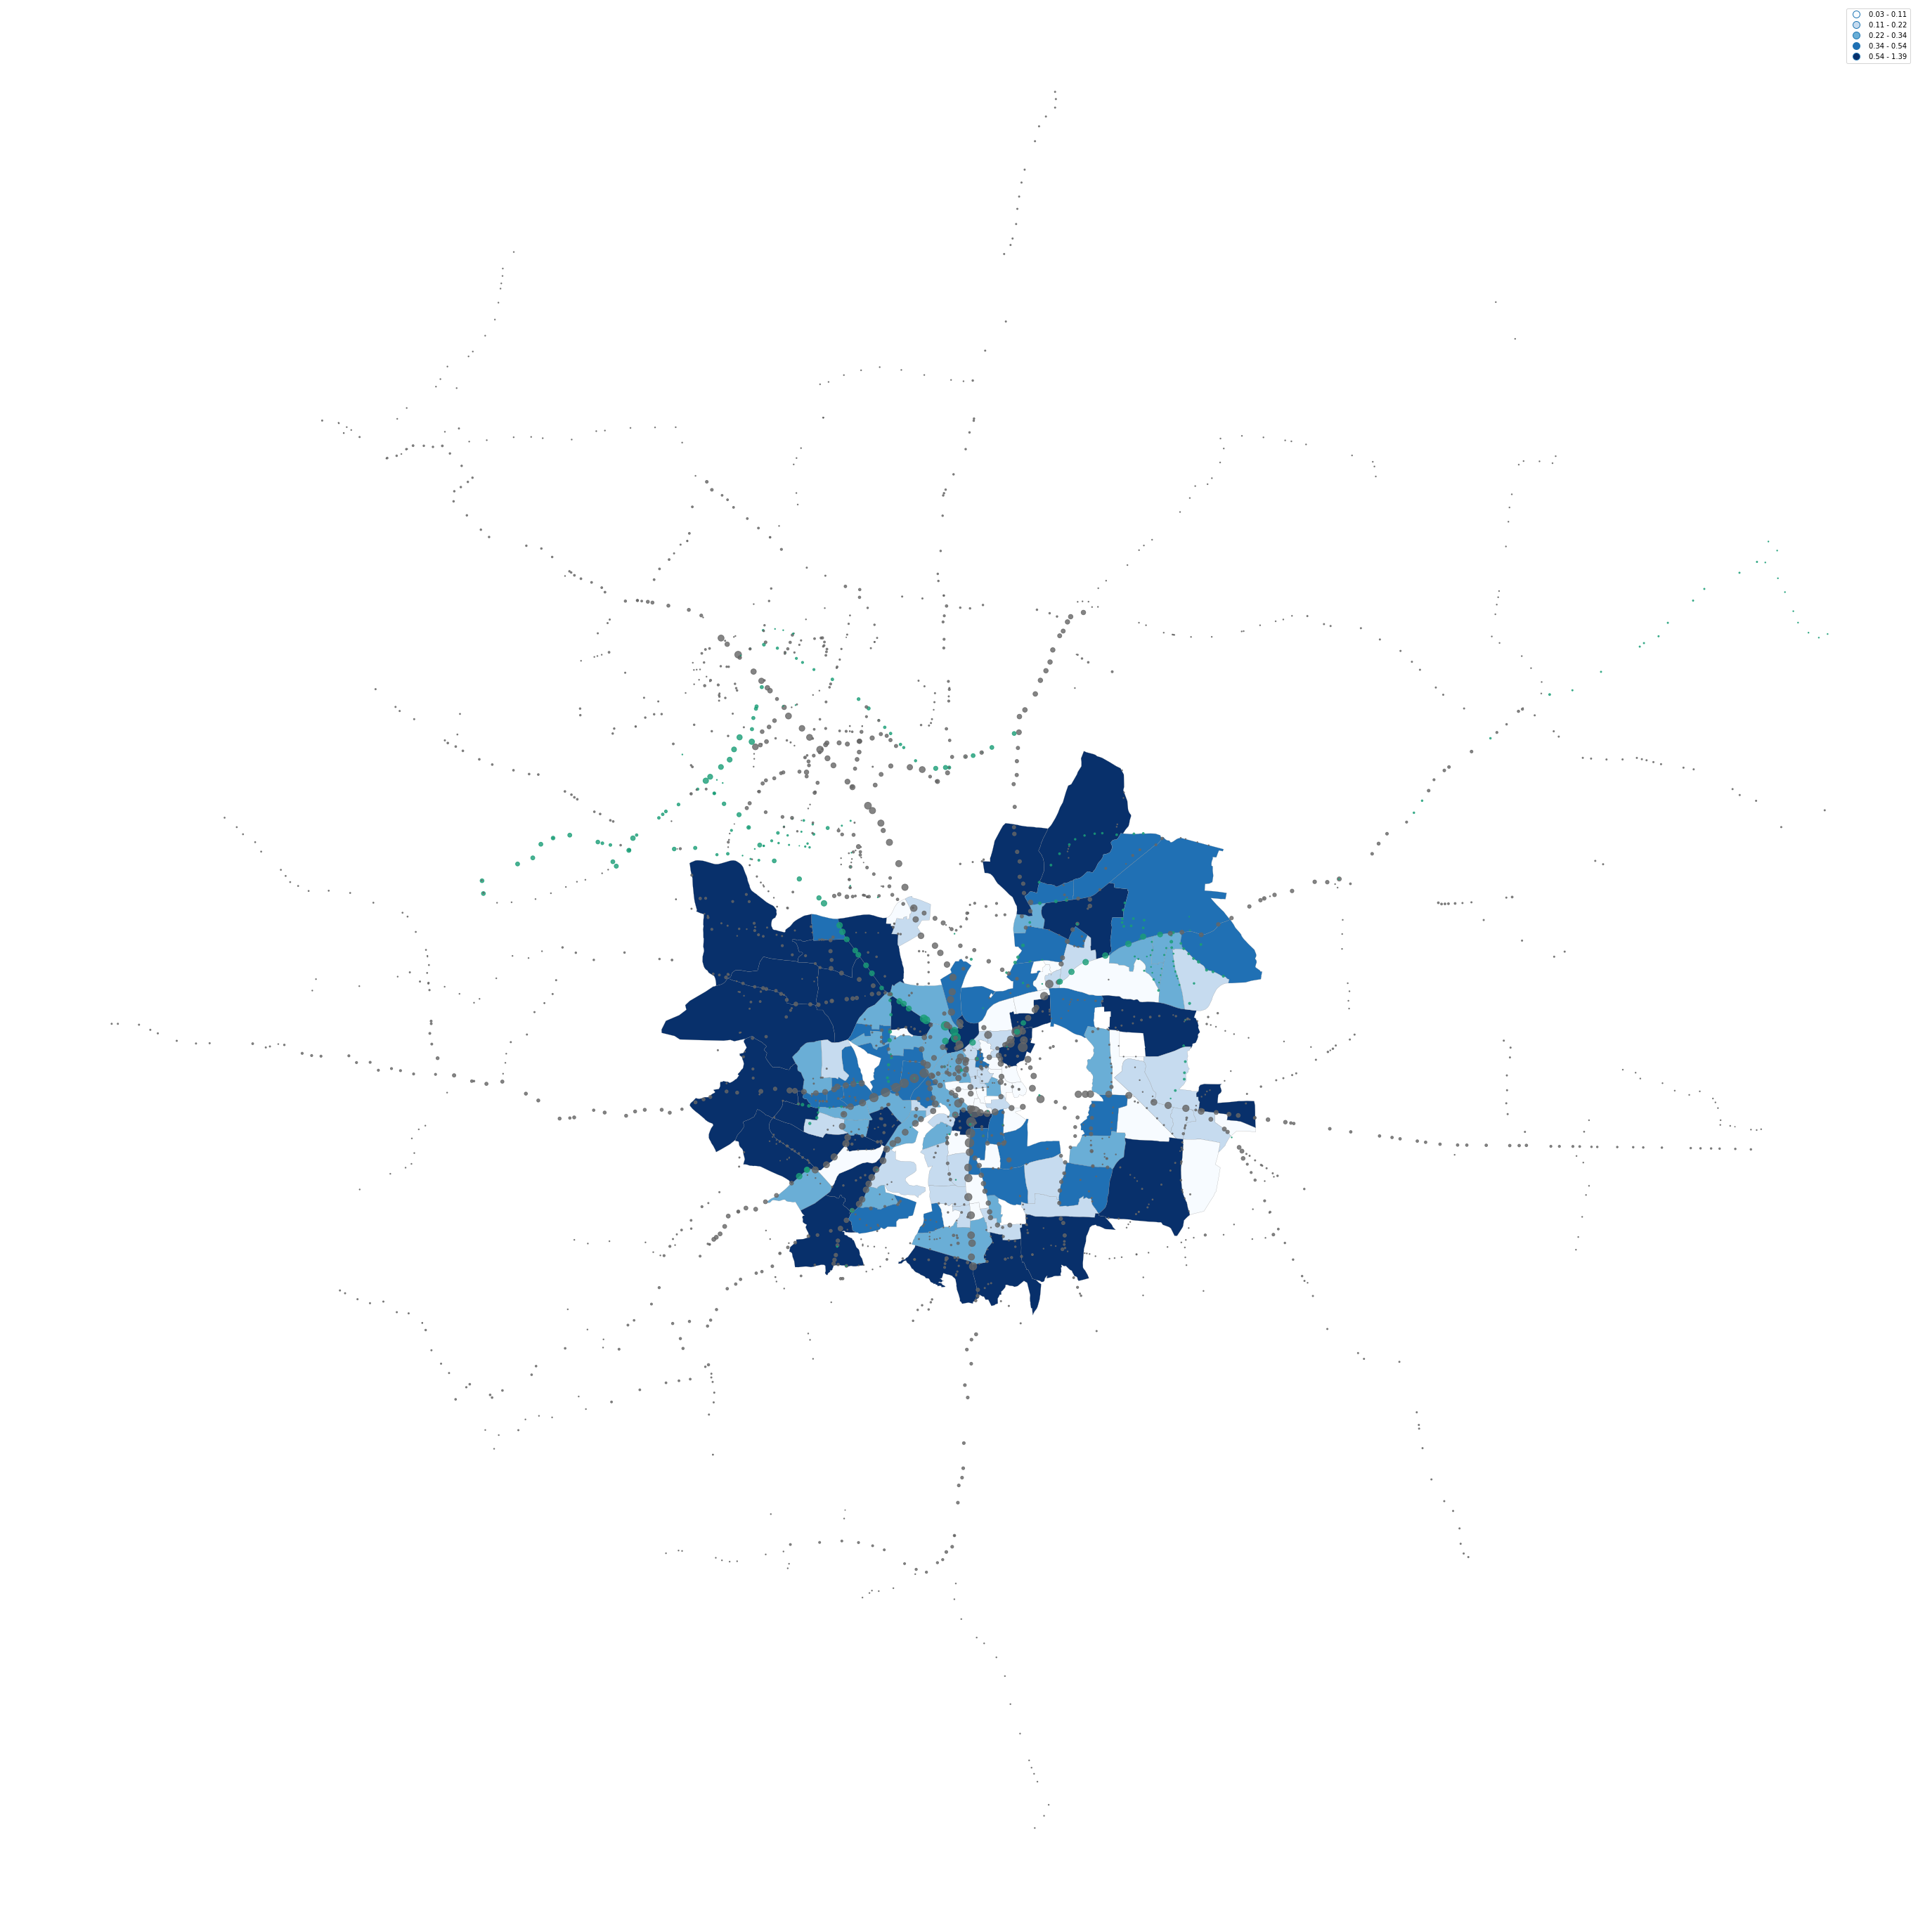

In [41]:
fig, ax = plt.subplots(figsize=(50, 50))

# plot the basemap: the country boundaries
ax = pnq_census.plot(ax=ax, 
                     column='stops_per_1000P', 
                     cmap = 'Blues',
                     edgecolor='grey', 
                     lw=0.2,
                     scheme = 'Quantiles',
                     k = 5,
                    legend = True)

# plot the points: the city lat-lngs
ax = pmpml.plot(ax=ax, column='Route.Type', cmap = 'Dark2', markersize = 'line_count', lw=1, alpha=0.8)

ax.axis('off')
plt.show()

### Mapping Population Density of a Census Ward with Bus stops:

Bus stops are marked by whether they are BRTS(green) or non-BRTS(grey), and sized according to the number of routes being served.

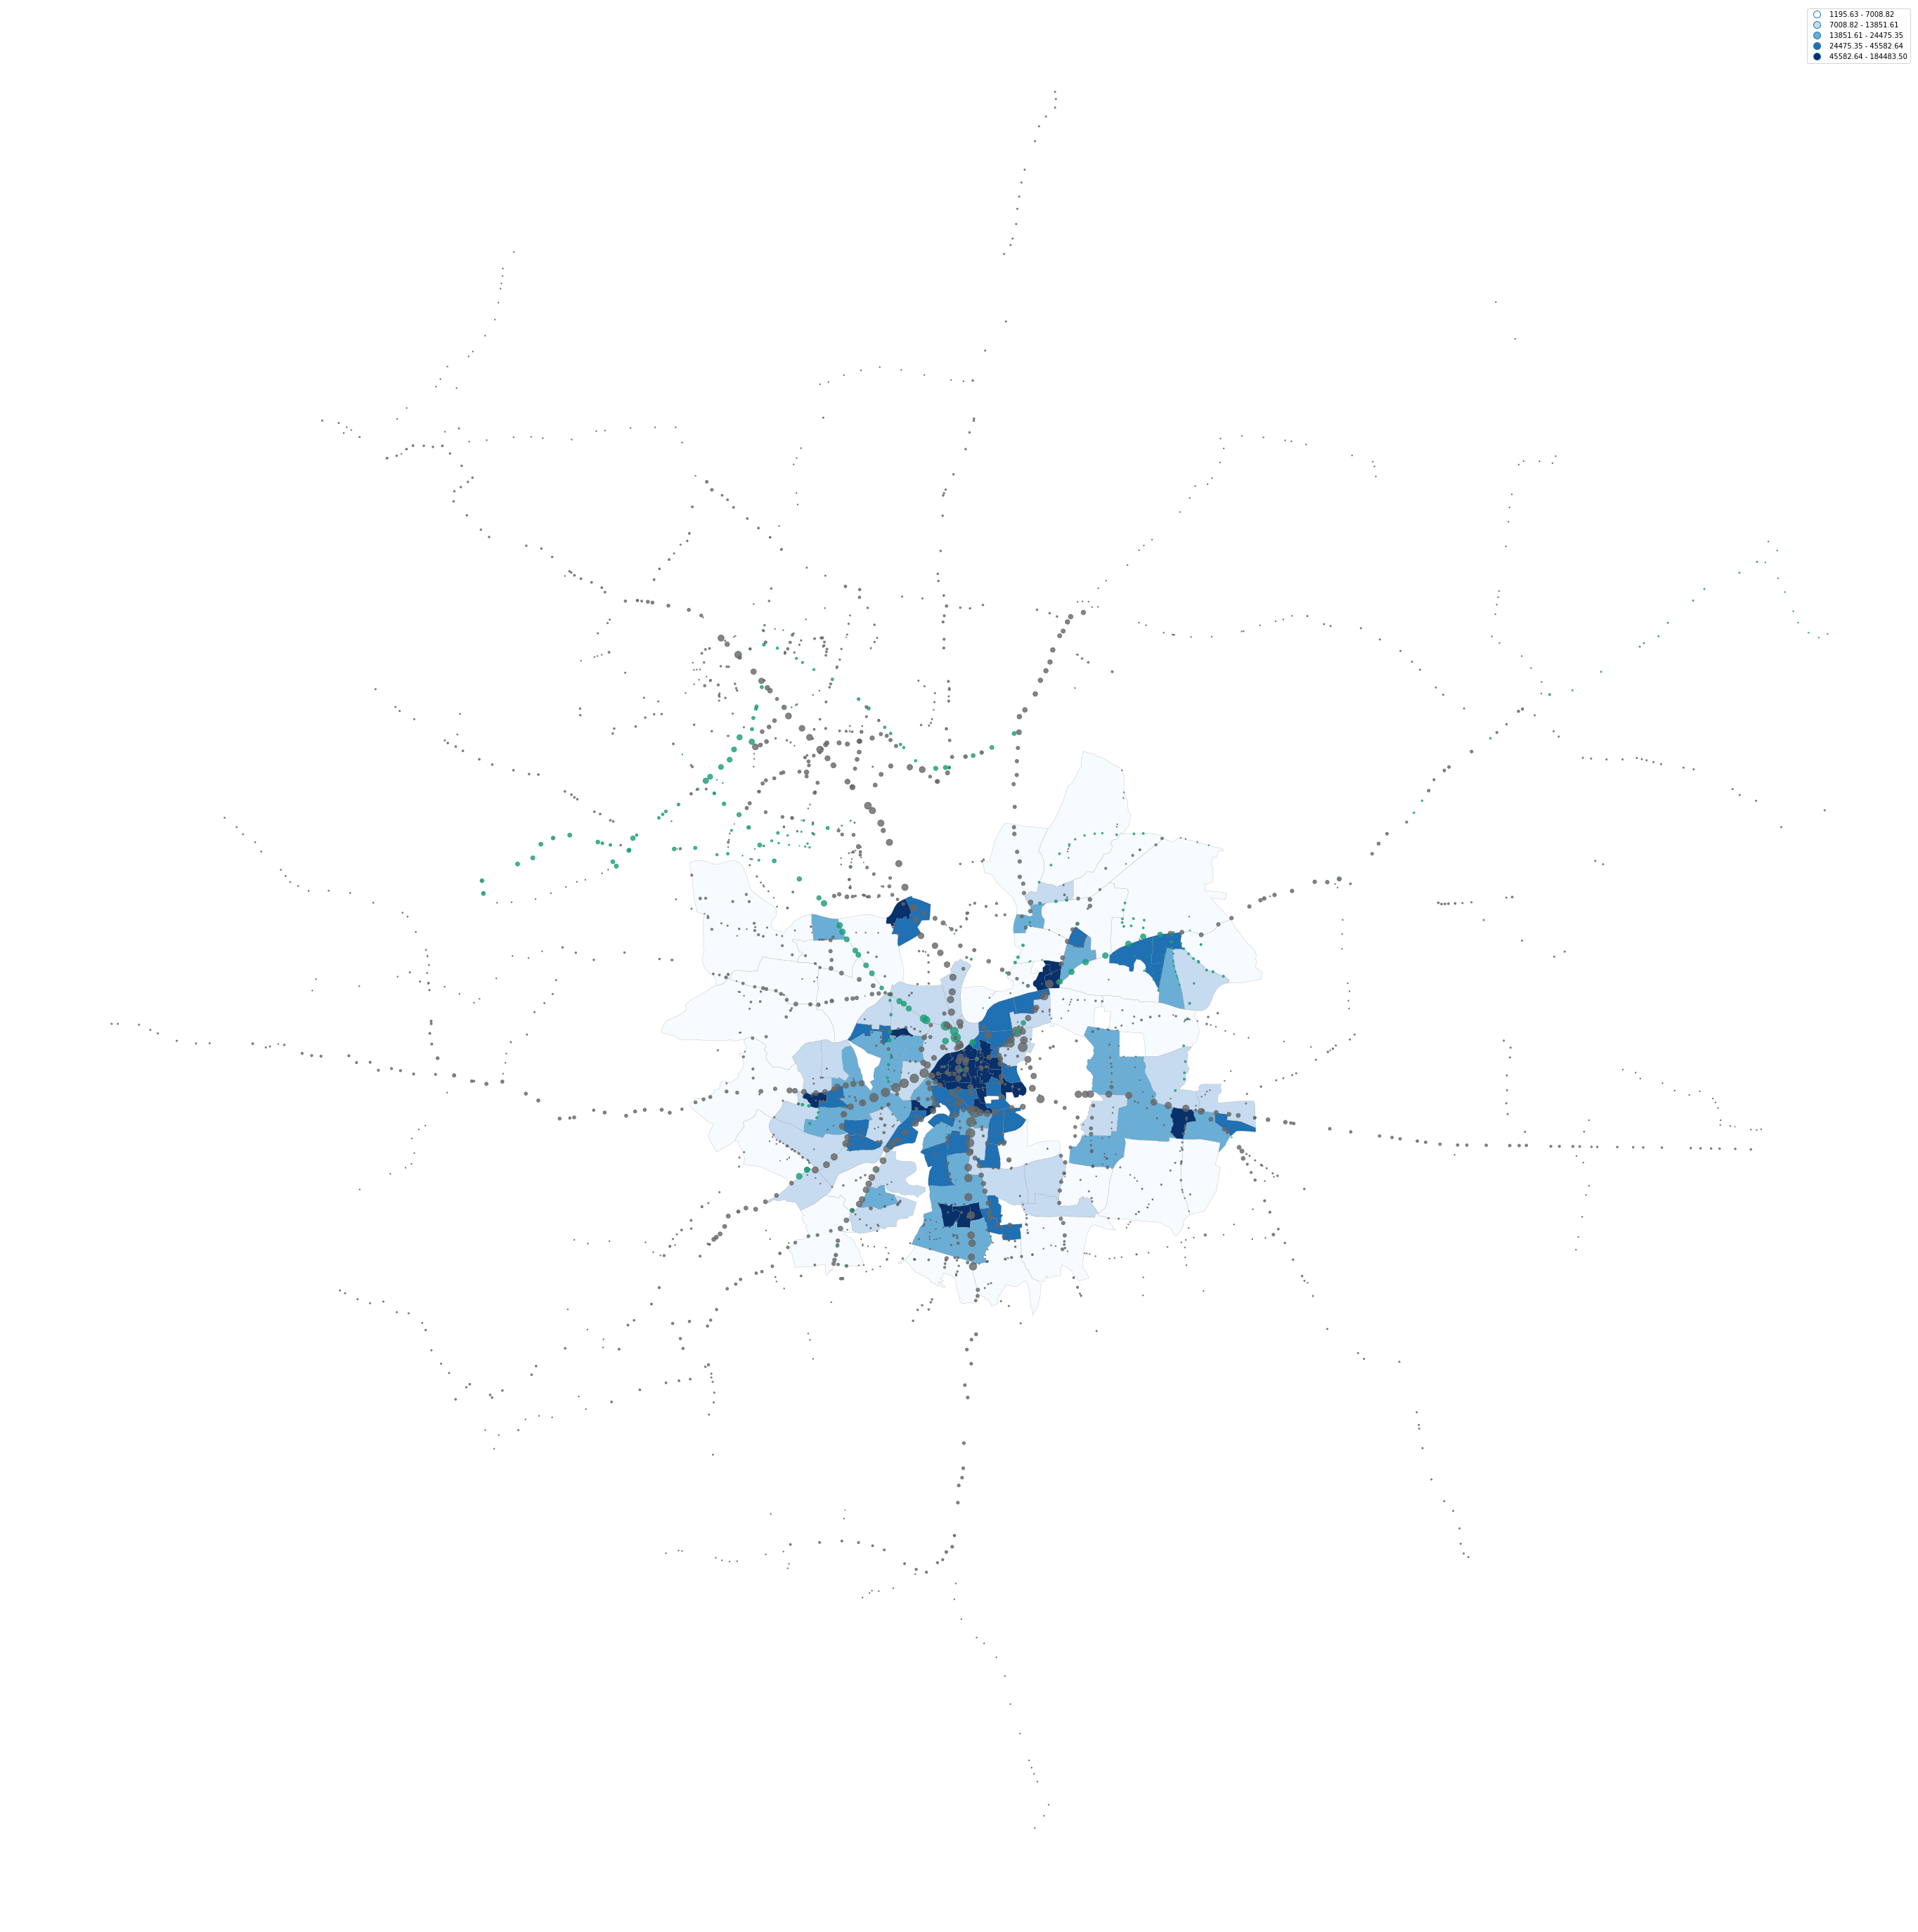

In [42]:
fig, ax = plt.subplots(figsize=(50, 50))

# plot the basemap: the country boundaries
ax = pnq_census.plot(ax=ax, 
                     column='pop_dens', 
                     cmap = 'Blues',
                     edgecolor='grey', 
                     lw=0.2,
                     scheme = 'Quantiles',
                     k = 5,
                    legend = True)

# plot the points: the city lat-lngs
ax = pmpml.plot(ax=ax, column='Route.Type', cmap = 'Dark2', markersize = 'line_count', lw=1, alpha=0.8)

ax.axis('off')
plt.show()

In [43]:
list(pnq_census)

['Ward',
 'No_HH',
 'TOT_P',
 'TOT_M',
 'TOT_F',
 'P_06',
 'M_06',
 'F_06',
 'P_SC',
 'M_SC',
 'F_SC',
 'P_ST',
 'M_ST',
 'F_ST',
 'P_LIT',
 'M_LIT',
 'F_LIT',
 'P_ILL',
 'M_ILL',
 'F_ILL',
 'TOT_WORK_P',
 'TOT_WORK_M',
 'TOT_WORK_F',
 'MAINWORK_P',
 'MAINWORK_M',
 'MAINWORK_F',
 'MAIN_CL_P',
 'MAIN_CL_M',
 'MAIN_CL_F',
 'MAIN_AL_P',
 'MAIN_AL_M',
 'MAIN_AL_F',
 'MAIN_HH_P',
 'MAIN_HH_M',
 'MAIN_HH_F',
 'MAIN_OT_P',
 'MAIN_OT_M',
 'MAIN_OT_F',
 'MARGWORK_P',
 'MARGWORK_M',
 'MARGWORK_F',
 'MARG_CL_P',
 'MARG_CL_M',
 'MARG_CL_F',
 'MARG_AL_P',
 'MARG_AL_M',
 'MARG_AL_F',
 'MARG_HH_P',
 'MARG_HH_M',
 'MARG_HH_F',
 'MARG_OT_P',
 'MARG_OT_M',
 'MARG_OT_F',
 'MARGWORK_3',
 'MARGWORK_1',
 'MARGWORK_2',
 'MARG_CL_3_',
 'MARG_CL__1',
 'MARG_CL__2',
 'MARG_AL_3_',
 'MARG_AL__1',
 'MARG_AL__2',
 'MARG_HH_3_',
 'MARG_HH__1',
 'MARG_HH__2',
 'MARG_OT_3_',
 'MARG_OT__1',
 'MARG_OT__2',
 'MARGWORK_0',
 'MARGWORK_4',
 'MARGWORK_5',
 'MARG_CL_0_',
 'MARG_CL__3',
 'MARG_CL__4',
 'MARG_AL_0_',
 'MARG_AL

### Mapping Population Density with median line count

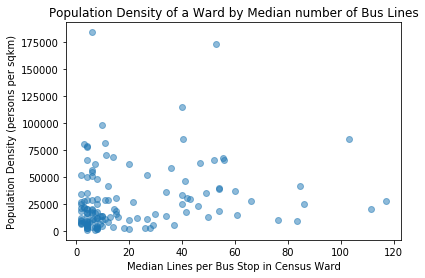

In [44]:
plt.scatter(y = pnq_census['pop_dens'],
            x = pnq_census['lines_median'],
            alpha=0.5)
plt.title('Population Density of a Ward by Median number of Bus Lines')
plt.xlabel('Median Lines per Bus Stop in Census Ward')
plt.ylabel('Population Density (persons per sqkm)')
plt.show()

In [45]:
gpd.GeoDataFrame.to_file(pnq_census, 'data/PCA_complete')